In [24]:

from rdkit import rdBase, Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdMolEnumerator,rdDepictor
from itertools import combinations,product
rdDepictor.SetPreferCoordGen(True)
print(rdBase.rdkitVersion)
IPythonConsole.drawOptions.addBondIndices = True###显示原子索引
IPythonConsole.drawOptions.addAtomIndices = True###显示原子索引
IPythonConsole.molSize = 400,400

2022.03.5


In [8]:
def add_dummy2smi(mol,i:int):
	dummy = Chem.Atom(0)  # 0 is the atomic number 
	rwmol = Chem.RWMol(mol)
	rwmol.AddBond(rwmol.AddAtom(dummy),i,Chem.rdchem.BondType.SINGLE)
	nums=rwmol.GetNumAtoms()
	smi=Chem.MolToSmiles(rwmol)
	return [smi,nums]

def split_bond2smi(mol,i:int):
	ibond=mol.GetBondWithIdx(i)
	begin=ibond.GetBeginAtomIdx()
	end=ibond.GetEndAtomIdx()
	rwmol=Chem.RWMol(mol)
	rwmol.RemoveBond(begin,end)
	rwmol.ReplaceAtom(begin,Chem.Atom(0))
	rwmol.ReplaceAtom(end,Chem.Atom(0))
	smi=Chem.MolToSmiles(rwmol)
	nums=rwmol.GetNumAtoms()
	dummy_index=[
		atom.GetIdx()+1 
		for atom in Chem.MolFromSmiles(smi,sanitize=False).GetAtoms() 
			if atom.GetSymbol() == "*"
	]
	return [smi,nums,*dummy_index]


In [9]:
from pydantic import BaseModel
from typing import Union,List,Set,Dict
class enumSetting(BaseModel):
	list:List[int]=[]
	range:List[float]=[]
	connect2index:List[int]=[]
	keepSame2Index:List[int]=[]
class core(BaseModel):
	id: int
	smiles: str
	enumAtoms:Dict[int, enumSetting]={}
	enumBonds:Dict[int, enumSetting]={}
class molecule(BaseModel):
  id: int
  smiles: str
  atoms: Dict[int,List[int]]={}
  bonds: Dict[int,List[int]]={} 
class enumData(BaseModel):
  core: core
  ligands: List[molecule]

In [10]:
core={
	'id':2,
	'smiles':'C1(C=CC=C2)=C2C(C=CC=C3)=C3[Si]1',
	'enumAtoms':{
        "2": {
            "list": [1,2,3,4 ],
            "range": [2, 4],
            "connect2index": [2,9],
            "keepSame2Index": []
        },
        "9": { 
	    	"list": [10,9,8],
            "range": [1,3],
            "connect2index": [2,9],
            "keepSame2Index": []
        }
	}
}


In [11]:
core['enumAtoms']['2'].get('list')

[1, 2, 3, 4]

In [12]:
ligands={
    "2": [
        [
            "*c1cccc2c1[Si]c1ccccc1-2",
            14
        ],
        [
            "*c1ccc2c(c1)[Si]c1ccccc1-2",
            14
        ],
        [
            "*c1ccc2c(c1)-c1ccccc1[Si]2",
            14
        ],
        [
            "*c1cccc2c1-c1ccccc1[Si]2",
            14
        ]
    ],
    "9": [
        [
            "*c1cccc2c1[Si]c1ccccc1-2",
            14
        ],
        [
            "*c1ccc2c(c1)[Si]c1ccccc1-2",
            14
        ],
        [
            "*c1ccc2c(c1)-c1ccccc1[Si]2",
            14
        ]
    ]
}

In [13]:
ligands['2']

[['*c1cccc2c1[Si]c1ccccc1-2', 14],
 ['*c1ccc2c(c1)[Si]c1ccccc1-2', 14],
 ['*c1ccc2c(c1)-c1ccccc1[Si]2', 14],
 ['*c1cccc2c1-c1ccccc1[Si]2', 14]]

In [14]:

combos=[{'2': [1, 3], '9': [10, 9]}]

In [15]:
def generateColorBase():
	colorbase={}
	for i in core['enumAtoms'].keys():
		colorbase[i]=[]
		for i1 in core['enumAtoms'][i]['connect2index']:
			colorbase[i].extend(ligands[str(i1)])
	return colorbase

In [16]:
for combo in combos:
	keys=combo.keys()
	for k in keys:
		print(len(combo[k]))

2
2


In [17]:
def enum_core_site(core:core):
	rateCombo={}
	for k in core['enumAtoms']:
		arr=core['enumAtoms'][k]['list']
		rate=sorted(core['enumAtoms'][k]['range'])
		rate[-1]=rate[-1]+1
		rateCombo[k]=[]
		for n in range(*rate):
			rateCombo[k].extend([list(i) for i in combinations(arr, n)])
	combo=[[*i] for i in product(*rateCombo.values())]
	colorIndex=rateCombo.keys()
	combo=map((lambda x : {v:x[i] for i,v in enumerate(colorIndex)}), combo)
	return combo

In [18]:
def getAtomCombos(core,ligands):#combos={colorindex:coresite[]}->
	#组合不同颜色的位点库
	mol=Chem.MolFromSmiles(core['smiles'])
	nums=mol.GetNumAtoms()
	colorbase={}
	for i in core['enumAtoms'].keys():
		colorbase[i]=[]
		for i1 in core['enumAtoms'][i]['connect2index']:
			colorbase[i].extend(ligands[str(i1)])
	#组合带有虚原子的smi
	t_combos=[]
	combos=enum_core_site(core)
	for combo in combos:
		keys=combo.keys()
		keys_combo=[]
		for k in keys:
			keys_combo.append([])
			length=len(combo[k])
			for combo_i in product(colorbase[k],repeat=length):
				_item=[]#[[smi,totalAtoms,site]]
				for i,_v in enumerate(combo_i): 
					_convert=_v.copy()
					_convert.append(combo[k][i])
					_item.append(_convert)
				keys_combo[-1].append(_item)
		for combo_color in product(*keys_combo):
			i=[c for com in combo_color for c in com]
			smis=core['smiles']
			site_n=nums
			link='m:'
			for item in i:
				smis=smis+'.'+item[0]
				link=link+str(site_n)+':'+str(item[-1])+','
				site_n=site_n+item[1]
			cxsmi=smis+' '+'|'+link+'|'
			t_combos.append(cxsmi)
	return t_combos
	

In [20]:
ss=getAtomCombos(core,ligands)
len(list(ss))

2078237

In [25]:
smis=["C1(C=CC=C2)=C2C(C=CC=C3)=C3[Si]1.*c1cccc2c1-c1ccccc1[Si]2.*c1ccc2c(c1)[Si]c1ccccc1-2.*c1ccc2c(c1)-c1ccccc1[Si]2.*c1cccc2c1[Si]c1ccccc1-2 |m:13:1,27:2,41:3,55:4,|",
"C1(C=CC=C2)=C2C(C=CC=C3)=C3[Si]1.*c1cccc2c1-c1ccccc1[Si]2.*c1ccc2c(c1)[Si]c1ccccc1-2.*c1ccc2c(c1)-c1ccccc1[Si]2.*c1ccc2c(c1)[Si]c1ccccc1-2 |m:13:1,27:2,41:3,55:4,|"]

In [26]:

def convert_smi(i:str)->str:
	mol=Chem.MolFromSmiles(i)
	smi=Chem.MolToSmiles(rdMolEnumerator.Enumerate(mol)[0])
	return smi

def parallel_convert_smis(smis_link:List[str])->List[str]:
	smis=Parallel(n_jobs=6)(delayed(convert_smi)(i) for i in smis_link)
	return smis


In [27]:

from joblib import Parallel, delayed

In [28]:
parallel_convert_smis(smis)

['c1ccc2c(c1)[Si]c1cc(-c3c(-c4cccc5c4-c4ccccc4[Si]5)c4c(c(-c5cccc6c5[Si]c5ccccc5-6)c3-c3ccc5c(c3)-c3ccccc3[Si]5)-c3ccccc3[Si]4)ccc1-2',
 'c1ccc2c(c1)[Si]c1cc(-c3c4c(c(-c5cccc6c5-c5ccccc5[Si]6)c(-c5ccc6c(c5)[Si]c5ccccc5-6)c3-c3ccc5c(c3)-c3ccccc3[Si]5)[Si]c3ccccc3-4)ccc1-2']

In [19]:
from joblib import Parallel, delayed
def fun1(i):
	mol=Chem.MolFromSmiles(i)
	smi=Chem.MolToSmiles(rdMolEnumerator.Enumerate(mol)[0])
	return smi
smis=Parallel(n_jobs=-1)(delayed(fun1)(i) for i in ss[:100000])

In [21]:
Chem.CanonSmiles(smis[0])==smis[0]

True

In [16]:

from typing import List
from typing import TypeVar,Iterable
S = TypeVar('S')
Response = Iterable[S]

def funsss(l:List[int])->Iterable[int]:
	return map(lambda x:x*2, l)


In [17]:
out=funsss(l=[1,2,3,4])

In [15]:
for i in out:
	out.

map

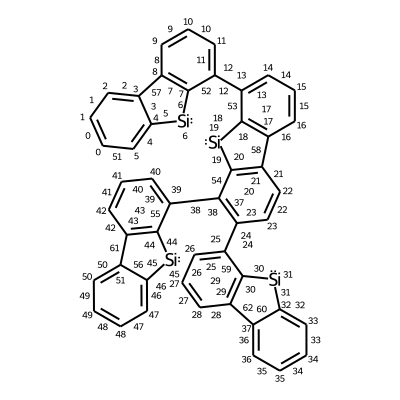

In [24]:
Chem.MolFromSmiles(smis[0])

In [25]:
smis=[]
for i in ss[:100000]:
	mol=Chem.MolFromSmiles(i)
	smis.append(Chem.MolToSmiles(rdMolEnumerator.Enumerate(mol)[0]))

In [ ]:
smis=list(set(smis))


In [ ]:
len(smis)

34

In [ ]:
smi=Chem.CanonSmiles('C1=CC=CC=C1')
smi

'c1ccccc1'

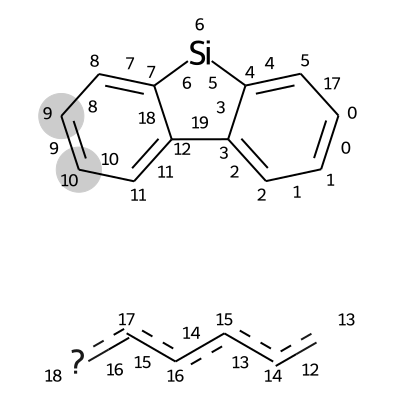

In [ ]:
mol=Chem.MolFromSmiles('c1ccc2c(c1)[Si]c1ccccc1-2.*:cccc:* |m:13:9,18:10,|',sanitize=False)
mol

In [ ]:

rwmol = Chem.RWMol(mol)
rwmol.AddBond(6,19,Chem.rdchem.BondType.SINGLE)
#nums=rwmol.GetNumAtoms()
#smi=Chem.MolToSmiles(rwmol)
out_smi=Chem.MolToSmiles(rwmol)

In [ ]:
Chem.CanonSmiles(out_smi)==out_smi

True

In [5]:
def fun(s:int)->int:
	s+=1
	return s

In [1]:
from joblib import Parallel,delayed

In [11]:
def fun(s:int)->int:
	s+=1
	return s
async def bar(n:int):
	out=Parallel(n_jobs=6)(delayed(fun)(i) for i in range(n))
	print('parallel done')
	return out

In [21]:
import asyncio
async def fun(s:int)->int:
	await asyncio.sleep(2)
	print('fun',s)
	return s
async def test(s:int):
	out=await fun(s)
	print('test')
	print(out)
	return out

In [22]:
await test(4)

fun 4
test
4


4

In [2]:
loop = asyncio.get_event_loop()

In [3]:
loop

<_WindowsSelectorEventLoop running=True closed=False debug=False>

In [1]:
#import nest_asyncio
#nest_asyncio.apply()
import asyncio
import time
async def func1():
    await asyncio.sleep(2)
    print('协程1')
    return 1

async def func2():
    await asyncio.sleep(1)
    print('协程2')
    return 2

async def func3():
    await asyncio.sleep(3)
    print('协程3')
    return 3
task = [func1(), func2(),func3()]
background_tasks = set()
async def main():
    for fun in task:
        task1=asyncio.create_task(fun)
        background_tasks.add(task1)
        task1.add_done_callback(background_tasks.discard)
    res=await asyncio.wait(background_tasks)
    return res
print(f"started at {time.strftime('%X')}")
ss=await main()
print(f"end at {time.strftime('%X')}")


started at 16:28:13
协程2
协程1
协程3
end at 16:28:16


In [17]:
from rdkit import Chem
from rdkit.Chem import Draw
mol=Chem.MolFromSmiles('C1=CC=C2C3=CC=CC=C3OC2=C1')
drawer = Draw.MolDraw2DSVG(300, 300)
drawer.DrawMolecule(mol)
drawer.FinishDrawing()
svg = drawer.GetDrawingText()
with open("mol1.svg", "w") as f:
    f.write(svg)

In [1]:

async def main():
  async with asyncio.TaskGroup() as tg:
    task1 = tg.create_task(func1())
    task2 = tg.create_task(func2())
    task3 = tg.create_task(func3())
    print(f"started at {time.strftime('%X')}")
  print(f"finished at {time.strftime('%X')}")

In [2]:
await main()

NameError: name 'asyncio' is not defined

In [1]:
import rdkit
from rdkit.Chem import CanonSmiles as cs

In [ ]:
for i in range(100000):
	smi=rdkit.Chem.CanonSmiles('C1=CC=CC=C1')

In [13]:

for i in range(100000):
	smi=cs('C1=CC=CC=C1')